In [1]:
import os
import pickle
import pandas as pd

dataframe_dir = os.path.join('../data')
with open(dataframe_dir+'/dataframe.pickle','rb') as file:
    data = pickle.load(file)
    
df = pd.DataFrame(data)
df.head(10)

,img,label,dim1,dim2
0,../data/cell_images\Uninfected\C161P122ThinF_I...,healthy,118,115
1,../data/cell_images\Uninfected\C88P49ThinF_IMG...,healthy,112,106
2,../data/cell_images\Parasitized\C136P97ThinF_I...,malaria,118,136
3,../data/cell_images\Uninfected\C52P13thinF_IMG...,healthy,130,130
4,../data/cell_images\Uninfected\C185P146ThinF_I...,healthy,115,103
5,../data/cell_images\Uninfected\C162P123ThinF_I...,healthy,127,118
6,../data/cell_images\Uninfected\C51AP12thinF_IM...,healthy,127,121
7,../data/cell_images\Parasitized\C140P101ThinF_...,malaria,154,166
8,../data/cell_images\Parasitized\C62P23N_ThinF_...,malaria,139,160
9,../data/cell_images\Parasitized\C59P20thinF_IM...,malaria,169,145


In [2]:
import datetime
datetime_now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print('Date-Time : ',datetime_now)

Date-Time :  20210515-090919


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\tensorflow\pyth

# Image Augmentation

In [4]:
split = 0.3
resize = (130,130)
seed = 1
batch_size = 32

train_datagen = ImageDataGenerator(validation_split = split,
                                   rescale=1./255,
                                   horizontal_flip = True,
                                   vertical_flip = True
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df,
    directory = None,
    x_col = 'img',
    y_col = 'label',
    target_size = resize,
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = True,
    seed = seed,
    subset = 'training'
)

validation_generator = train_datagen.flow_from_dataframe(
    df,
    directory = None,
    x_col = 'img',
    y_col = 'label',
    target_size = resize,
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False,
    subset = 'validation'
)

Found 9628 validated image filenames belonging to 2 classes.
Found 4126 validated image filenames belonging to 2 classes.


# Build Basic CNN
We will use the LeNet-5 CNN Architecture (1998) which is very basic arsitecture for convolutional neural network.

image below: 
* https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/
* https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b

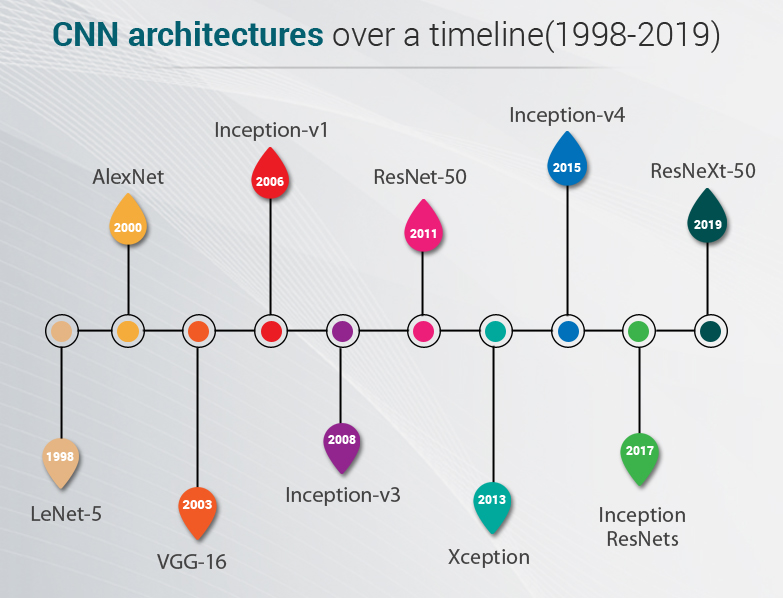

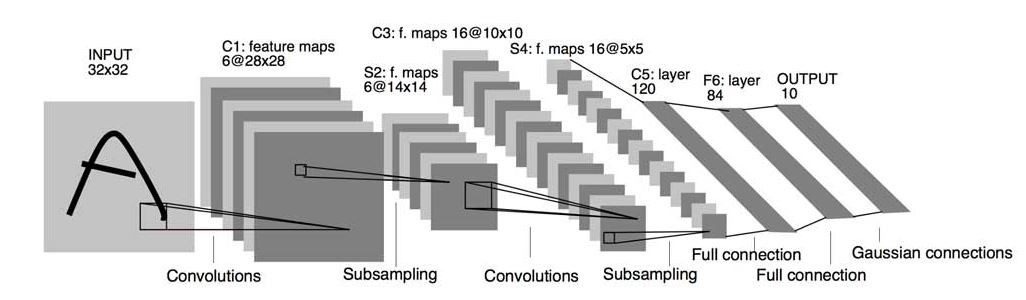

In [5]:
input_shape = resize + (3,)

model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=input_shape))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(130,130,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 63, 63, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 29, 29, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 13456)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               1614840   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164     
__________

In [7]:
epoch = 10

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = epoch,
                              validation_data = validation_generator,
                              validation_steps=len(validation_generator))

Epoch 1/10
301/301 [==============================] - 287s 955ms/step - loss: 0.5654 - acc: 0.6991 - val_loss: 0.2492 - val_acc: 0.9052
Epoch 2/10
301/301 [==============================] - 18s 58ms/step - loss: 0.2767 - acc: 0.9040 - val_loss: 0.2110 - val_acc: 0.9237
Epoch 3/10
301/301 [==============================] - 54s 180ms/step - loss: 0.2485 - acc: 0.9153 - val_loss: 0.2050 - val_acc: 0.9278
Epoch 4/10
301/301 [==============================] - 42s 141ms/step - loss: 0.2066 - acc: 0.9317 - val_loss: 0.1852 - val_acc: 0.9384
Epoch 5/10
301/301 [==============================] - 54s 179ms/step - loss: 0.2014 - acc: 0.9331 - val_loss: 0.1743 - val_acc: 0.9384
Epoch 6/10
301/301 [==============================] - 40s 134ms/step - loss: 0.1786 - acc: 0.9377 - val_loss: 0.1715 - val_acc: 0.9421
Epoch 7/10
301/301 [==============================] - 39s 130ms/step - loss: 0.1771 - acc: 0.9413 - val_loss: 0.1760 - val_acc: 0.9338
Epoch 8/10
301/301 [==============================] - 4

C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Dell\.conda\envs\tf-gpu_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  Fut

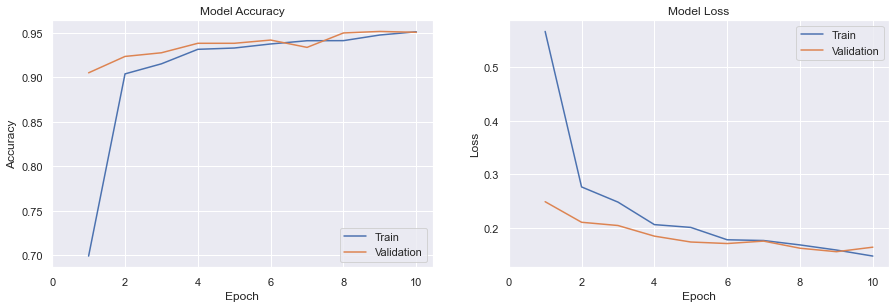

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
epochlist = range(1,epoch+1)

plt.figure(1,figsize=(15,10))

plt.subplot(2,2,1)
sns.lineplot(epochlist, history.history['acc'])
sns.lineplot(epochlist, history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(0,epoch+1,2))
plt.legend(['Train','Validation'])
plt.title('Model Accuracy')

plt.subplot(2,2,2)
sns.lineplot(epochlist, history.history['loss'])
sns.lineplot(epochlist, history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0,epoch+1,2))
plt.legend(['Train','Validation'])
plt.title('Model Loss')

fig_dir = '../output/plot/'
figname = fig_dir+'acc_loss_'+datetime_now+'.png'
plt.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [9]:
model_dir = '../output/model/'
model_name = model_dir+'basic_CNN '+ datetime_now+'.h5'

model.save(model_name)